# Assignment 3: Neural Networks for Quantum State Tomography

In this assignment you will train a neural network to fit the distribution of a quantum state from few measurements of it. Even though this problem has applications in physics, for the purpose of this exercise we will mainly consider it as a regression problem, without concerning us with the physics behind it.

## Introducing the problem: Quantum State Tomography

We are given a dataset with $N$ samples $\{x_i,y_i \}_{i = 1, ..., N}$ where $x_i = \{0,1\}^{\mathtt{n\_spins}}$ is a binary string of length $\mathtt{n\_spins}$ and $y_i \in (0,1]$ is a  number. We have our regression problem.

But where is the data from? We are considering the case where the $x_i$ are the the possible outcomes of a measurement of a quantum state $\Psi$ and $y_i$ is the probability of observing outcome $x_i$.
Our goal is to train a neural network $f_\theta(x) = \hat{y}$ that approximates the original probability distribution. Specifically, for the set of possible outcomes $\{x_i\}$, the model should return a vector of probabilities corresponding to each outcome.


## Exercise 1 (10 pts): A fully connected network

For the purpose of this exercise, we give you a function that samples $N$ measurements from a quantum state along with their probabilities.

In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


def get_data(n_spins):
    
    # Loads the data available in the .txt files we made available to you.
    
    if n_spins not in [8,12,16]:
        raise ValueError(f"The data for {n_spins} is not available.")
        
    numbers = [bin(i)[2:].zfill(n_spins) for i in range(2**n_spins)]
    xs = [[int(char) for char in string] for string in numbers]
    X = np.array(xs)
    
    Wstate = np.loadtxt(f"target_state_{n_spins}.txt")
    Y = np.abs(Wstate)**2
    
    # shuffle
    idx = np.random.permutation(range(len(Y)))
    
    return X[idx], Y[idx]

a) Load the data for `n_spins=16` and visualize the labels as a histogram. Visualize both `y` and `log(y)` in different plots. Which representation is more informative?

*Answer:* The logarithm is clearly more informative representation, since we are talking about log-probabilities in the range $[0,1]$, where probabilities go down to as much as $P \sim 10^{-20}$. We also see the log-transform resembles a quantum wave function in a sense.

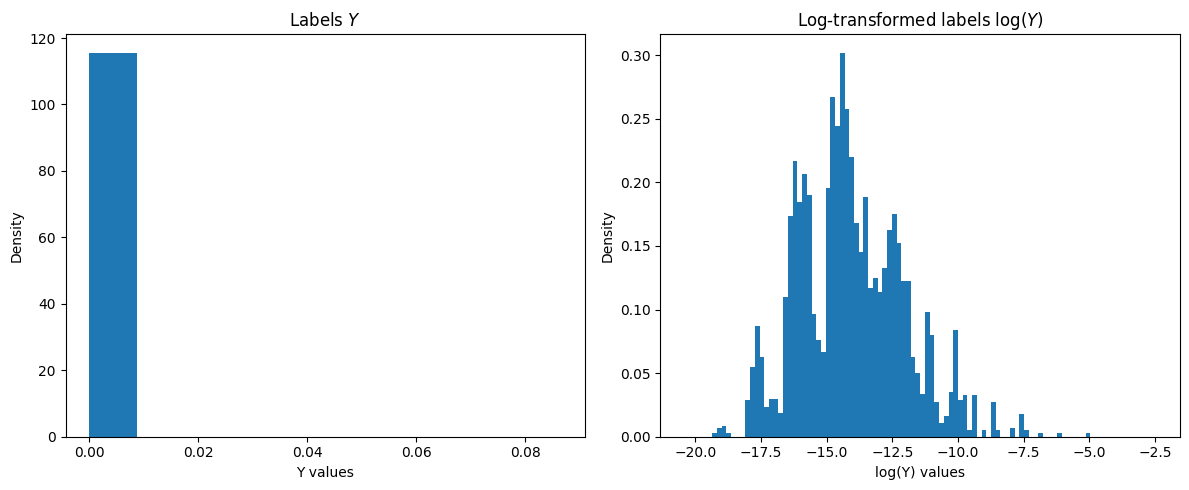

In [2]:
X, Y = get_data(16)

# your code here
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Y
axs[0].hist(Y, density=True)
axs[0].set_title('Labels $Y$')
axs[0].set_xlabel('Y values')
axs[0].set_ylabel('Density')

#log-transformed Y
axs[1].hist(np.log(Y), bins=100, density=True)
axs[1].set_title(r'Log-transformed labels $\log(Y)$')
axs[1].set_xlabel('log(Y) values')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()


b) We want to continue working with this datasets in two different forms, either without or with the log-transform of the labels : $\{x_i,y_i\}$ or $\{x_i,log(y_i)\}$. Then we want to train neural networks on this data using SGD. 

Complete the function `get_loaders`. Set `n_spins=12` and apply the log transform according to the normalize variable. Create a test, train and validation dataset using `TensorDataset`, the split should be done at (40%,20%,40%) of the original data. To prepare for training, wrap the new datasets in torch `DataLoaders` as you have seen in previous exercises. For training data loader, use a batch size 32 and use shuffling, for test and validation data loaders use the full batch and don't shuffle. 

In [3]:
def get_loaders(X, Y, normalize_log):
    n_spins = 12
    X = X[:, :n_spins]

    # log condition
    if normalize_log:
        Y = np.log(Y)

    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))

    # splitting the datasets
    total_size = len(dataset)
    train_size = int(0.4 * total_size)
    test_size = int(0.2 * total_size)
    val_size = total_size - train_size - test_size # Ensure correct split sizes
    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # generate dataloaders
    train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=len(val_set), shuffle=False)
    test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)

    return train_loader, val_loader, test_loader

c) Define a general function `train` as given below that takes the test and train loaders, a learning rate and a model, a number of epochs and optionally a boolean `logging`equal to `True` by default and returns the train and test losses for every epoch, and the best test loss achieved overall. 

You are supposed to run SGD with the MSE loss. Print the progress of your training by printing the losses every epoch, if `logging==True`.

- I) In the course of your code you will use the line `optimizer.zero_grad()`. Explain briefly what happens when you call this function, and when and why you need to call it.

- II)  Explain why we previously needed to activate the batches and shuffling for the training dataloader. 

- III) When a dataloader is used several times for several epochs, is the data shuffled in the same order every time?

*`Answers:`* 
- I) When you call `optimizer.zero_grad()`, you set the gradients to zero before backpropagation. You want to do this for every batch during the training phase because PyTorch stockpiles the gradients, which affect the next step in optimization so we wish to reset it.

- II ) Since we use SGD optimizer, activating batches and shuffling makes sure we avoid local minimas in SGD by shuffling and making it random. This reduces bias in batch selection and mitigates overfitting.

- III ) Since we activated `shuffle=True`, the data is shuffled in **different order** every time.

In [4]:
def train(train_loader, test_loader, lr, model, n_epochs, logging=True, device = "cpu"):
    model.to(device)

    train_losses, test_losses = [], []
    loss_fn = nn.MSELoss()  # MSE LOSS
    optimizer = optim.SGD(model.parameters(), lr=lr) #SGD OPTIMIZAR

    for t in range(n_epochs):
        model.train()
        epoch_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device).unsqueeze(1)
            y_pred = model(X_train)
            train_loss = loss_fn(y_pred, y_train)

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_train_loss += train_loss.item()


        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        # test set
        model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device).unsqueeze(1)
                y_test_pred = model(X_test)
                test_loss += loss_fn(y_test_pred, y_test).item()
                
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if logging:
            print(f"Epoch {t+1}/{n_epochs} | Train loss: {epoch_train_loss:.6f} | Test loss: {test_loss:.6f}")
        
        # stop around 0.01 loss
        if test_loss < 0.011:
            break

    best_test_loss = min(test_losses)
    return train_losses, test_losses, best_test_loss


d) Test your function by training a 1 hidden layer fully connected network with ReLU activations. You will choose the hyperparameters: `n_epochs` to train and the `learning rate`. You can keep the number of `hidden_neurons=16` fixed for the moment. Hint: You should not need to use more than 2000 epochs in your explorations...

Write the code to train and visualize the test and train losses with a log-sacle on the y-axis.
It is now your turn to play.

Choose `lr=0.1`, `n_epochs=100` and `hidden_neurons=16`. Train 10 models with these hyperparameters and observe their learning curves. We would expect the learning curves of the 10 different models to be different because every time you define a new model, the weights are initialized randomly and the SGD optimizer will go over the batches in a different order. 

Describe what differences and similarities you observe. How could you change (some of) the hyperparameters so that the runs are more similar, i.e. the loss curve is less strongly dependent on the initialization?

> ⚠️ Once you are ready to answer the question, leave the code you used for your explorations and the learning curves you produced, but comment it so we don't have to run it again. This hold only for this question

*`Answer:`* The similarities are that the learning curves are oscillating and converge after a certain number of epochs. We could adjust the learning rate to avoid overfitting, which in turn reduces the oscillations that are caused by large variance in the model.

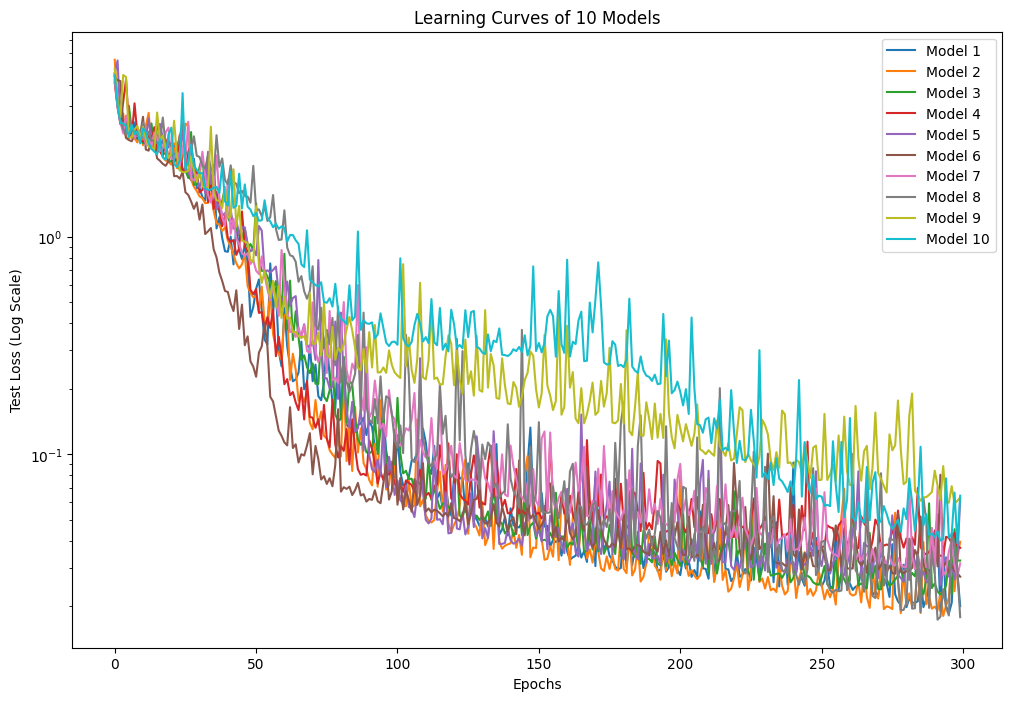

In [5]:
# Correct model based on input and output shapes
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_neurons, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_neurons, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 12 # Number of spins
hidden_neurons = 16
output_size = 1
learning_rate = 0.01
n_epochs = 300
X, Y = get_data(12)

train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=True) #loaders 

plt.figure(figsize=(12, 8))

for i in range(10): # 10 different models trained
    torch.manual_seed(i) 
    model = SimpleNN(input_size, hidden_neurons, output_size)
    train_losses, test_losses, _ = train(train_loader, test_loader, learning_rate, model, n_epochs, logging=False)
    plt.plot(test_losses, label=f'Model {i+1}')

plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Test Loss (Log Scale)')
plt.title('Learning Curves of 10 Models')
plt.legend()
plt.show()

e) Choose some parameters that reliably give you good models even if you restart the training . If you get a test loss around 0.01 you can stop training. 

*`Answer:`* A slightly higher learning rate will ensure that the model is not overfitting, and also more epochs ensures convergence toward 0.01.

In [6]:
### GPT GENERATED - SAVING MODEL ###
best_model = None
best_test_loss = float('inf')
best_model_index = -1
best_model_path = "best_model.pth" 

In [7]:
# Hyperparameters
input_size = 12 # Number of spins
hidden_neurons = 16
output_size = 1
learning_rate = 0.0095
n_epochs = 500
train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=True) #loaders 

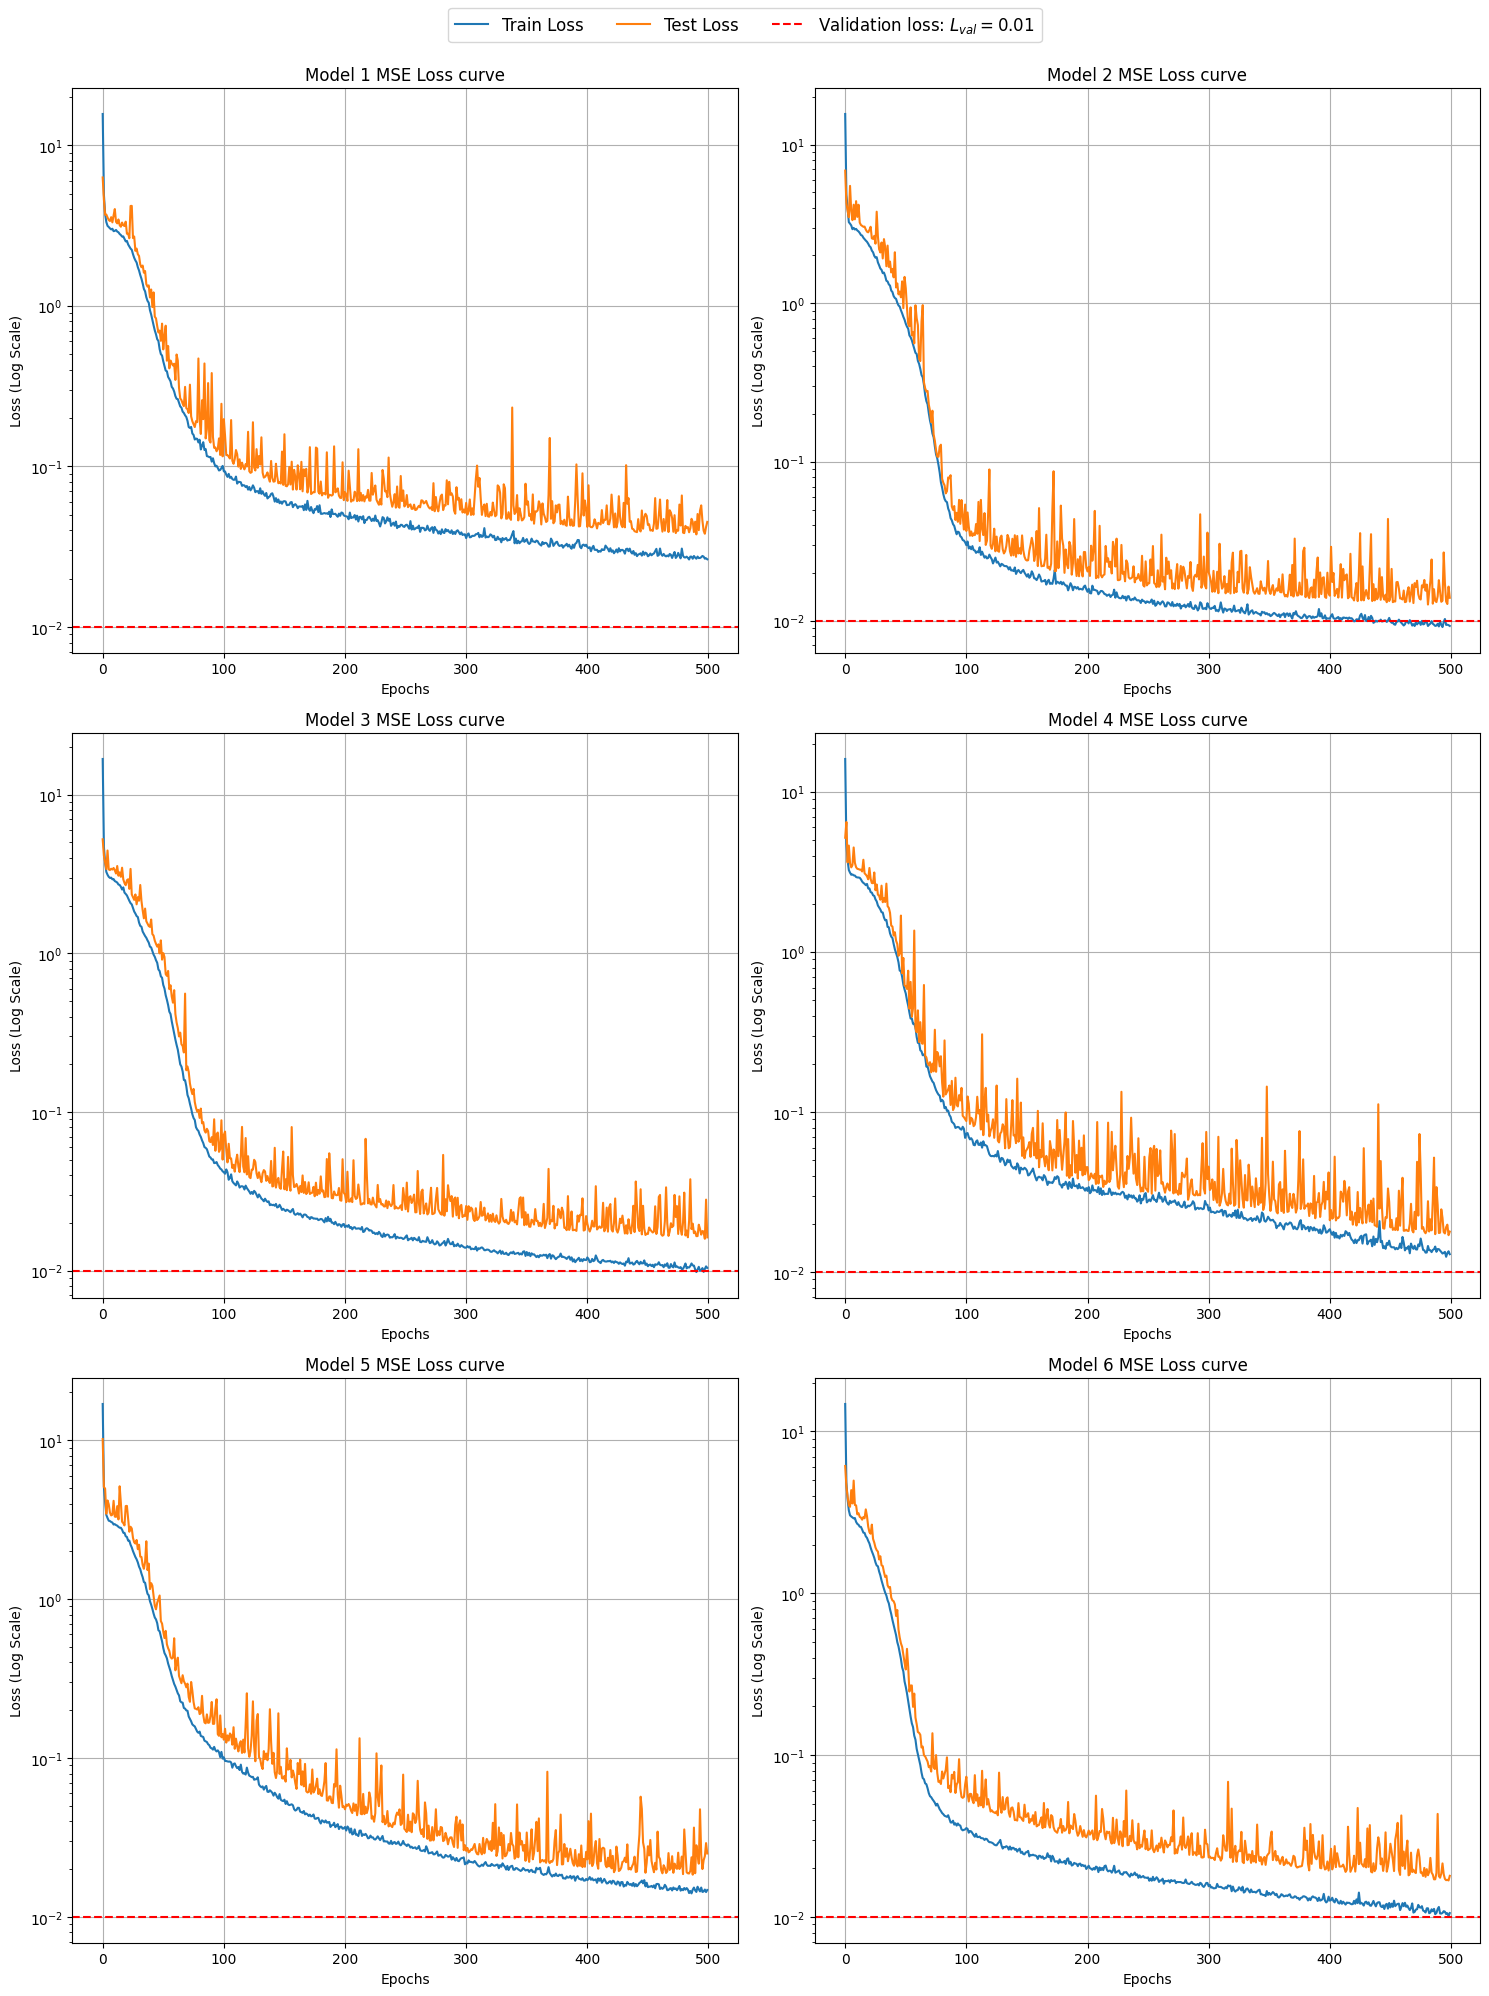

The best model is Model 2 with a test loss of 0.012655.
The best model has been saved to best_model.pth.


In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
axes = axes.flatten()

# Trainining 6 different models
for i in range(6):
    torch.manual_seed(i)  # random seeds
    model = SimpleNN(input_size, hidden_neurons, output_size)
    train_losses, test_losses, test_loss = train(train_loader, test_loader, learning_rate, model, n_epochs, logging=False)

    # tracking best model
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = model
        best_model_index = i + 1 

    ax = axes[i]
    ax.plot(train_losses, label='Train Loss')
    ax.plot(test_losses, label='Test Loss')
    ax.axhline(y=0.01, c="red", linestyle="--", label=r"Validation loss: $L_{val} = 0.01$")
    ax.set_yscale('log')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (Log Scale)')
    ax.set_title(f'Model {i+1} MSE Loss curve')
    ax.grid(True)

lines, labels = [], []
for ax in axes:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
fig.legend(lines[:3], labels[:3], loc="upper center", ncol=3, fontsize=12, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.975]) 
plt.show()

print(f"The best model is Model {best_model_index} with a test loss of {best_test_loss:.6f}.")
print(f"The best model has been saved to {best_model_path}.")


f) For the previous model that you liked, plot the histogram of the distribution again with the log transform, for test data. Also plot the predicted and ground truth values against each other. Are you satisfied with the match?

*`Answer:`* 

The structure/shape of the probability distribution matches the trend generally well. However, it struggles to capture the high density areas around $Y = [10^{-11},10^{-8}]$, as is seen in the middle of the histogram. I am generally satisfied with the match, but could do some minor tweaks to mitigate the density errors.

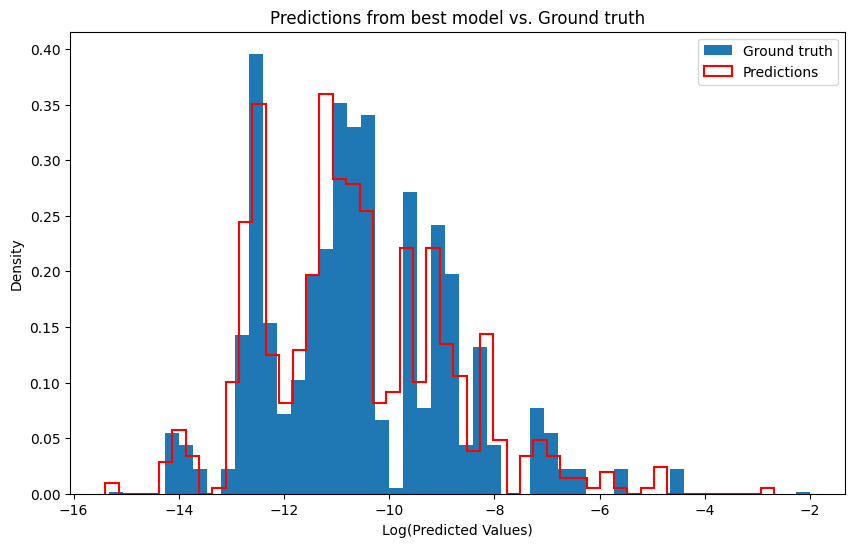

In [9]:
device = "cpu"
best_model = SimpleNN(input_size, hidden_neurons, output_size)
best_model.load_state_dict(torch.load("best_model.pth", weights_only=True))
best_model.to(device)
best_model.eval()
train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=True) #loaders 

X_test, Y_test = test_loader.dataset[:]
X_test = X_test.to(device)
Y_test = Y_test.to(device)

#using best model
torch.manual_seed(42)
with torch.no_grad():
    y_pred = best_model(X_test)

bin_count=50
plt.figure(figsize=(10, 6))
plt.hist(np.log(Y), bins = bin_count, density=True,label="Ground truth")
plt.hist(y_pred.squeeze().cpu().numpy(), bins=bin_count, density=True,  histtype="step",  linewidth=1.5, label="Predictions", color="red")
plt.xlabel("Log(Predicted Values)")
plt.ylabel("Density")
plt.title("Predictions from best model vs. Ground truth")
plt.legend()
plt.show()


## Exercise 2 (6 pts): Exploring alternative architectures  and losses

You have found a model that works! But can you make it more efficient?

a) A linear regression model would for example use fewer parameters. Try the model and based on your experiment argue that it is less suitable for this task than the fully connected neural network.

*`Answer:`* 

**Scatterplot 1**: 
We can see below that the data is non-linear. Linear regression can't fit a linear relationship with binary string $X$ and log-probabilities $Y$. The features are flat (binary), and logistic regression would maybe (?) be more fitting (no pun intended).

**Scatterplot 2**: A good model would align all points along diagonal $y=x$, here it is clear the LR model fails.

**Histogram**: In the histogram, the linear regression has very sharp peak at one spot, meaning it just predicts same value regardless of the log-probabilty.


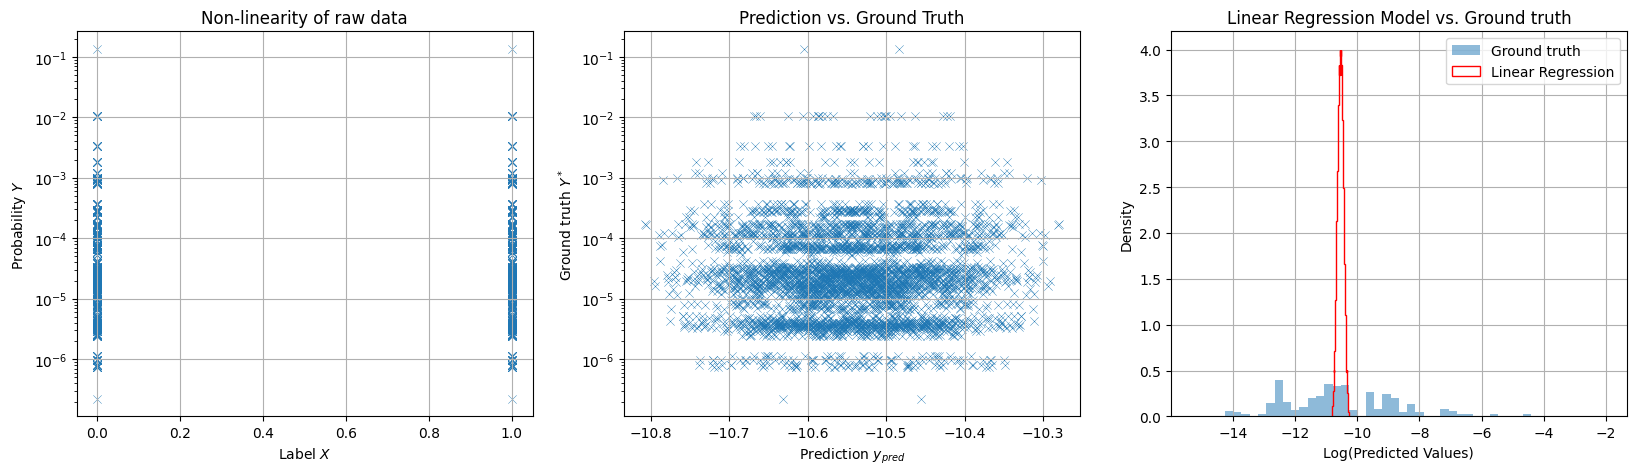

In [10]:
from sklearn.linear_model import LinearRegression

train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=True) #loaders 
X_train, Y_train = train_loader.dataset[:]
LR = LinearRegression()
LR.fit(X_train, Y_train)

# Predictions
with torch.no_grad():
    y_pred_LR = LR.predict(X)

# Subplots setup
fig, axs = plt.subplots(1,3, figsize=(20, 5))

# First plot: Non-linearity of raw data
axs[0].set_title("Non-linearity of raw data")
axs[0].scatter(X[:, 0], Y, marker="x", linewidths=0.3)
axs[0].set_xlabel("Label $X$")
axs[0].set_ylabel("Probability $Y$")
axs[0].set_yscale("log")
axs[0].grid(True)

# Second plot: Prediction vs. Ground Truth
axs[1].set_title("Prediction vs. Ground Truth")
axs[1].scatter(y_pred_LR, Y, marker="x", linewidths=0.3)
axs[1].set_xlabel(r"Prediction $y_{pred}$")
axs[1].set_ylabel(r"Ground truth $Y^*$")
axs[1].set_yscale("log")
axs[1].grid(True)

# Third plot: Histogram of predictions vs. ground truth
bin_count = 50
axs[2].hist(np.log(Y), bins=bin_count, density=True, label="Ground truth", alpha=0.5)
axs[2].hist(y_pred_LR, bins=bin_count, density=True, histtype="step", linewidth=1, label="Linear Regression", color="red")
axs[2].set_xlabel("Log(Predicted Values)")
axs[2].set_ylabel("Density")
axs[2].set_title("Linear Regression Model vs. Ground truth")
axs[2].legend()
axs[2].grid(True)

b) If a linear regression does not work, maybe you can fine-tune the number of hidden neurons. Select 5 different values of the hidden neurons `[2,8,16,32,64]` and train those models. Use at max 500 epochs to train every model and a learning rate of 0.01. In reality you would optimize the learning rate for each architecture and you can still do so if you wish, but to save you time we do not require this. After the models are trained, select the best one based on the best test loss. 

Estimate the loss you can expect on the model that you just selected on a fresh data sample, that has not been seen in the process of selecting this model. 

*`Answer:`* The test loss is slightly worse due to overfitting, so we assume some 5-10\% increase in loss compared to validation. So for our best model with 16 hidden neurons, we have for the validation loss $0.01$ that

$$
Loss \approx 0.01 \times [1+5\%, 1+10\%] = [0.0105, 0.011].
$$

If we have no test set, we use the loss $[0.0105, 0.011]$ as a baseline for selection bias and determine how good the model can generalize a fresh unseen data sample.

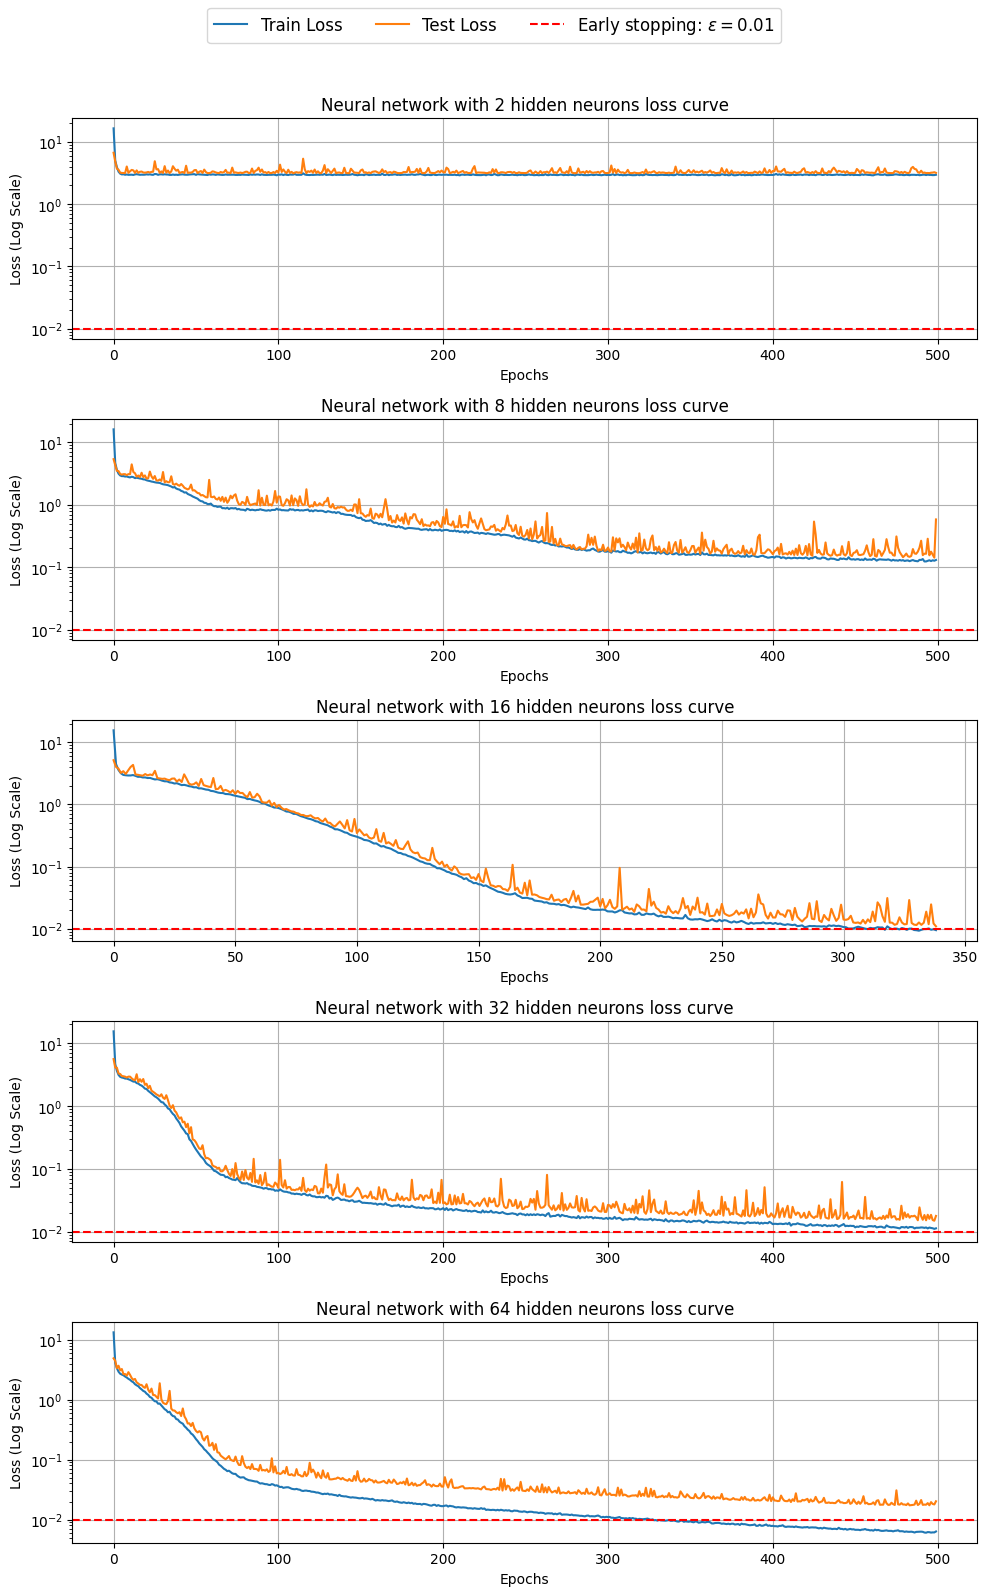

Best hidden neuron amount is:  16


In [11]:
hidden_neurons_list = [2,8,16,32,64]
n_epochs = 500
lr = 0.01
train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=True) #loaders 

axes = axes.flatten()
i = 0
best_losses = []

fig, axes = plt.subplots(5, 1, figsize=(10, 16))
for hidden_neuron in hidden_neurons_list:
    torch.manual_seed(42) 
    i+=1
    model = SimpleNN(input_size, hidden_neuron, output_size)
    train_losses, test_losses, best_test_loss = train(train_loader, test_loader, learning_rate, model, n_epochs, logging=False)
    best_losses.append(best_test_loss)

    ax = axes[i-1]
    ax.plot(train_losses, label='Train Loss')
    ax.plot(test_losses, label='Test Loss')
    ax.axhline(y=0.01, c="red", linestyle="--", label=r"Early stopping: $\epsilon = 0.01$")
    ax.set_yscale('log')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (Log Scale)')
    ax.set_title(f'Neural network with {hidden_neuron} hidden neurons loss curve')
    ax.grid(True)

lines, labels = [], []
for ax in axes:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
fig.legend(lines[:3], labels[:3], loc="upper center", ncol=3, fontsize=12, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

print("Best hidden neuron amount is: ", hidden_neurons_list[np.argmin(best_losses)])

c) Now you want to see what difference the log transformation we applied at the very beginning makes. Train a model on the plain data and compare the models prediction again both via the histogram of y-values and the scatterplot between the predicted and true y, in the log transform. What did the non-log transformed model learn and why?

*`Answer:`* Neural networks assume that the data does not have large differences in values. We see that the data spans anything from $10^{-16}$ to $10^{-2}$. We are using MSE, which cause a **bias toward large values**, thats why the histogram is shifted all the way to the right and the scatterplot is only clustered for largest values. The non-log transformed training models only the states in high probability range, and ignores the low probability states which are very important to capture in quantum state tomography. In the scatter plot, we also observe that the model is not fitting correctly, since we should have a $y=x$ line.

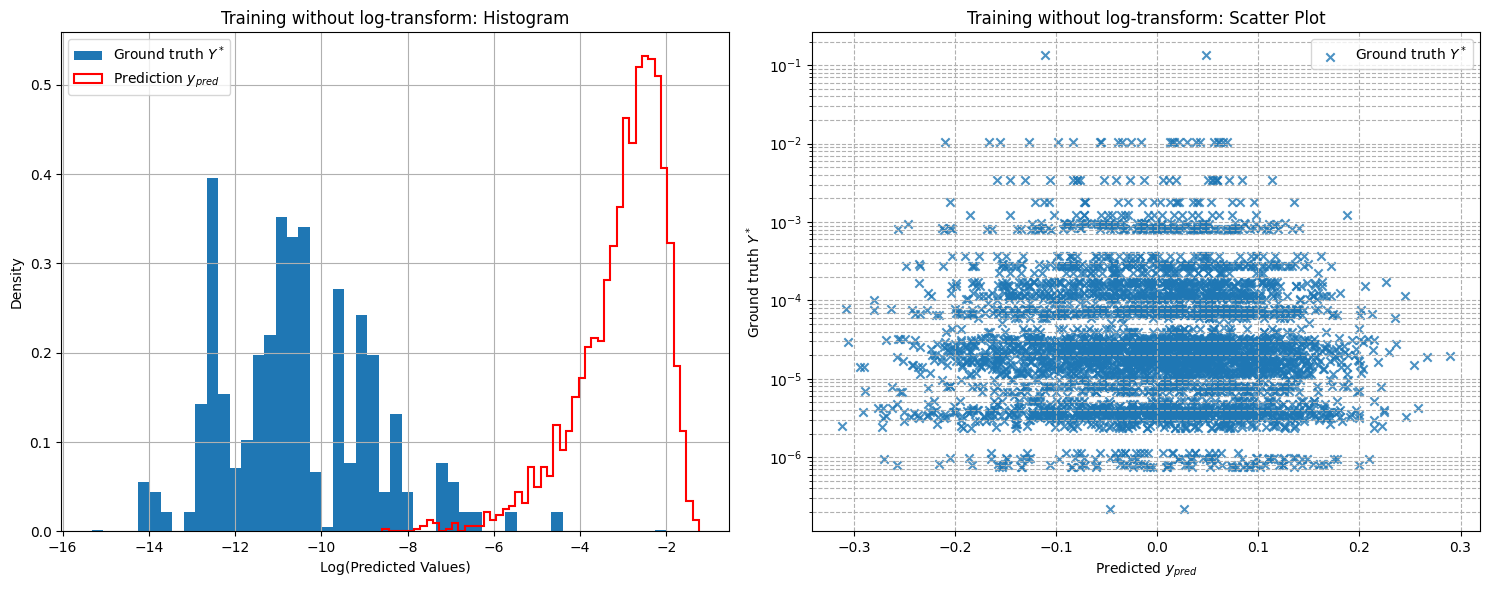

In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
# Hyperparameters
input_size = 12 # Number of spins
hidden_neurons = 16
output_size = 1
learning_rate = 0.01
n_epochs = 500

X,Y = get_data(12)

train_loader, val_loader, test_loader = get_loaders(X, Y, normalize_log=False) #loaders 
model = SimpleNN(input_size, hidden_neurons, output_size)
train(train_loader, test_loader, lr, model, n_epochs, logging=False)
X_tensor = torch.tensor(X, dtype=torch.float32)
model.eval()

with torch.no_grad():
    y_pred = model(X_tensor)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].set_title("Training without log-transform: Histogram")
axs[0].hist(np.log(Y), bins=50, density=True, label=r"Ground truth $Y^*$")
axs[0].hist(np.log(y_pred.numpy()), bins=50, density=True, label=r"Prediction $y_{pred}$", histtype="step", linewidth=1.5, color="red")
axs[0].set_xlabel("Log(Predicted Values)")
axs[0].set_ylabel("Density")
axs[0].legend()
axs[0].grid(True)

axs[1].set_title("Training without log-transform: Scatter Plot")
axs[1].scatter(y_pred.numpy(), Y, label=r"Ground truth $Y^*$", marker='x', alpha=0.8)
axs[1].set_xlabel(r"Predicted $y_{pred}$")
axs[1].set_ylabel(r"Ground truth $Y^*$")
axs[1].set_yscale("log")
axs[1].grid(True, which="both", linestyle="--")
axs[1].legend()

plt.tight_layout()
plt.show()